In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pysal
!pip install contextily

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [ ]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline
from libpysal.weights import Queen
from esda.moran import Moran
from esda.moran import Moran_Local
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

(254, 8)


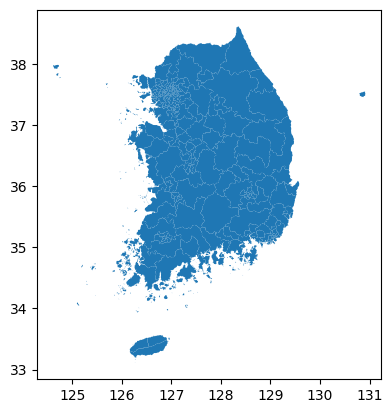

In [ ]:
result_gdf = gpd.read_file('/content/drive/My Drive/2024 Congressional Election/final_result.geojson')
result_gdf.plot()
print(result_gdf.shape)

In [ ]:
result_gdf.head()

,SIDO,SGG,votes cast,democratic party,ppp,SGG_Code,SIDO_SGG,geometry
0,Seoul,종로,83465,44713,38752,2110101,서울 종로,"POLYGON ((127.02314 37.57802, 127.01483 37.582..."
1,Seoul,중구성동갑,123930,65204,58726,2110402,서울 중구성동갑,"POLYGON ((127.05622 37.52833, 127.06747 37.548..."
2,Seoul,중구성동을,120689,61728,58961,2110201,서울 중구성동을,"POLYGON ((127.03581 37.53583, 127.02881 37.549..."
3,Seoul,용산,127056,60473,66583,2110301,서울 용산,"POLYGON ((126.98041 37.50654, 126.98555 37.506..."
4,Seoul,광진갑,102986,54105,48881,2110501,서울 광진갑,"POLYGON ((127.11523 37.55676, 127.1064 37.5564..."


In [ ]:
print(pd.isnull(result_gdf['democratic party']).sum())
print(pd.isnull(result_gdf['ppp']).sum())
print(pd.isnull(result_gdf['votes cast']).sum())

0
0
0


In [ ]:
def calculate_wasted_votes(row):
    dem = row['democratic party']
    ppp = row['ppp']
    total = row['votes cast']
    half = total / 2

    if dem > ppp:
        dem_wasted = dem - half
        ppp_wasted = ppp
    else:
        dem_wasted = dem
        ppp_wasted = ppp - half

    return pd.Series({
        'dem_wasted': dem_wasted,
        'ppp_wasted': ppp_wasted,
        'discrepancy': dem_wasted - ppp_wasted
    })

In [ ]:
result_gdf[['dem_wasted', 'ppp_wasted', 'discrepancy']] = result_gdf.apply(calculate_wasted_votes, axis=1)

In [ ]:
result_gdf.head(100)

,SIDO,SGG,votes cast,democratic party,ppp,SGG_Code,SIDO_SGG,geometry,dem_wasted,ppp_wasted,discrepancy
0,Seoul,종로,83465,44713,38752,2110101,서울 종로,"POLYGON ((127.02314 37.57802, 127.01483 37.582...",2980.5,38752.0,-35771.5
1,Seoul,중구성동갑,123930,65204,58726,2110402,서울 중구성동갑,"POLYGON ((127.05622 37.52833, 127.06747 37.548...",3239.0,58726.0,-55487.0
2,Seoul,중구성동을,120689,61728,58961,2110201,서울 중구성동을,"POLYGON ((127.03581 37.53583, 127.02881 37.549...",1383.5,58961.0,-57577.5
3,Seoul,용산,127056,60473,66583,2110301,서울 용산,"POLYGON ((126.98041 37.50654, 126.98555 37.506...",60473.0,3055.0,57418.0
4,Seoul,광진갑,102986,54105,48881,2110501,서울 광진갑,"POLYGON ((127.11523 37.55676, 127.1064 37.5564...",2612.0,48881.0,-46269.0
...,...,...,...,...,...,...,...,...,...,...,...
95,Gwangju,서구을,64397,58037,6360,2290202,광주 서구을,"POLYGON ((126.88363 35.13762, 126.88037 35.138...",25838.5,6360.0,19478.5
96,Gwangju,북구갑,95569,86713,8856,2290401,광주 북구갑,"POLYGON ((126.90716 35.15145, 126.91248 35.155...",38928.5,8856.0,30072.5
97,Gwangju,북구을,109870,99993,9877,2290402,광주 북구을,"POLYGON ((126.88417 35.16973, 126.89151 35.168...",45058.0,9877.0,35181.0
98,Gwangju,광산갑,80420,74102,6318,2290501,광주 광산갑,"POLYGON ((126.82884 35.14931, 126.82528 35.153...",33892.0,6318.0,27574.0


* The Freedom to Vote Act defines a gerrymandering threshold as a partisan advantage of 7% or one congressional district, whichever is greater.
* For South Korea, the required population ratio is different, for example, population of one district must be in range of +-33% of average.
# So, we will have to adjust threshold higher than US, as there are much more variance in populations leading to higher number of wasted votes.

In [ ]:
pos_threshold = 0.12
neg_threshold = -0.12

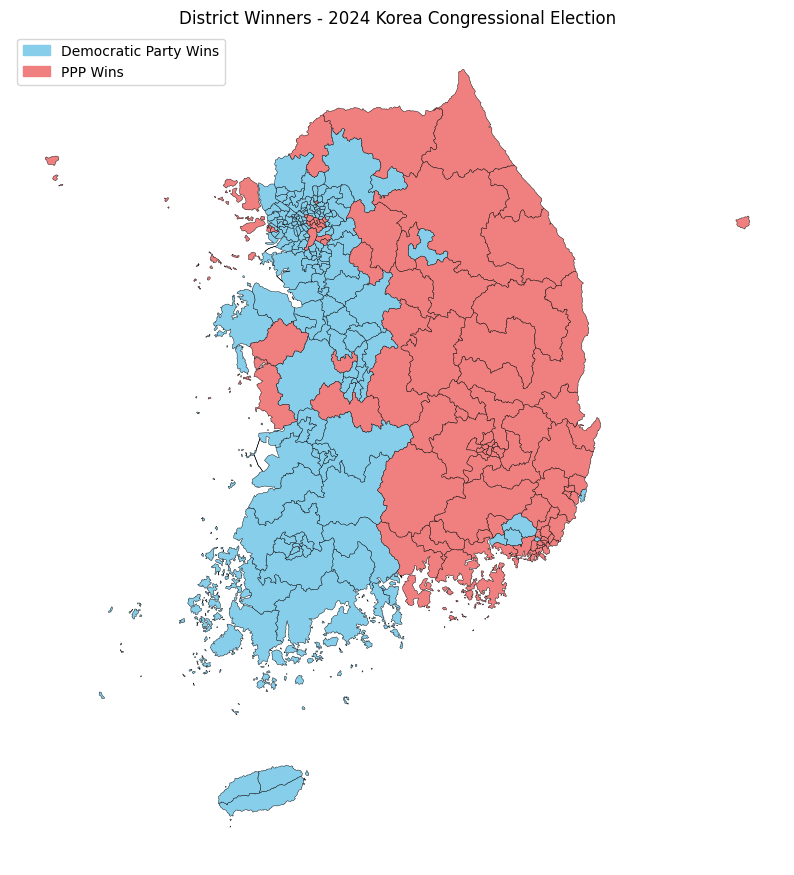

In [ ]:
# First, visualize the result of election.
def classify_winner(row):
    if row['democratic party'] > row['ppp']:
        return 'skyblue'    # Democrat win
    else:
        return 'lightcoral'     # PPP win

result_gdf['winner_color'] = result_gdf.apply(classify_winner, axis=1)


fig, ax = plt.subplots(1, 1, figsize=(10, 12))
result_gdf.plot(ax=ax, color=result_gdf['winner_color'], edgecolor='black', linewidth=0.3)


import matplotlib.patches as mpatches
legend_elements = [
    mpatches.Patch(color='skyblue', label='Democratic Party Wins'),
    mpatches.Patch(color='lightcoral', label='PPP Wins'),
]
ax.legend(handles=legend_elements, loc='upper left')


ax.set_title('District Winners - 2024 Korea Congressional Election')
plt.axis('off')
plt.show()


# Efficiency gap can be computed by computing the total discrepancy of certain region, in this case, we will get the efficiency gap of every prefecture of South Korea.
* If the value is positive, then the region is structured in favor of Democratic Party.
* If the value is negative, the region is structured in favor of PPP.
* If the value is located between positive and negative thresholds, then the district is not biased to any party.

In [ ]:
def compute_efficiency_gap_for_sido(sido_name):
    # Filter for one SIDO
    sido_df = result_gdf[result_gdf['SIDO'] == sido_name]

    # Calculate total wasted votes for each party
    total_dem_wasted = sido_df['dem_wasted'].sum()
    total_ppp_wasted = sido_df['ppp_wasted'].sum()
    total_votes = sido_df['votes cast'].sum()

    # Efficiency gap for this SIDO
    efficiency_gap = (total_dem_wasted - total_ppp_wasted) / total_votes

    # Classify based on the threshold
    if efficiency_gap > pos_threshold:
        bias = 'Democratic Bias'
    elif efficiency_gap < neg_threshold:
        bias = 'PPP Bias'
    else:
        bias = 'Fair'

    return efficiency_gap, bias

# Compute and classify for each SIDO
sido_results = []
for sido in result_gdf['SIDO'].unique():
    efficiency_gap, bias = compute_efficiency_gap_for_sido(sido)
    sido_results.append({'SIDO': sido, 'efficiency_gap': efficiency_gap, 'bias': bias})

# Convert results to DataFrame
sido_df = pd.DataFrame(sido_results)

# Display the results
print(sido_df)

         SIDO  efficiency_gap             bias
0       Seoul       -0.219415         PPP Bias
1       Busan        0.364055  Democratic Bias
2       Daegu        0.175251  Democratic Bias
3     Incheon       -0.261502         PPP Bias
4     Gwangju        0.313853  Democratic Bias
5     Daejeon       -0.382140         PPP Bias
6       Ulsan        0.275320  Democratic Bias
7      Sejong        0.057081             Fair
8    Gyeonggi       -0.292800         PPP Bias
9     Gangwon        0.111085             Fair
10   Chungbuk       -0.167980         PPP Bias
11   Chungnam       -0.273645         PPP Bias
12    Jeonbuk        0.220330  Democratic Bias
13    Jeonnam        0.255121  Democratic Bias
14  Gyeongbuk        0.118776             Fair
15  Gyeongnam        0.133587  Democratic Bias
16       Jeju       -0.266282         PPP Bias


* Urban areas like Seoul and Incheon are leaning towards PPP, but with a negative efficiency gap, showing that districts may be drawn to favor PPP in these regions, even if the actual vote totals in the cities suggest Democratic dominance.
* Rural regions, such as Jeonnam, Gyeongnam, and Daegu, show a Democratic bias, where Democrats seem to win more efficiently, consolidating votes in fewer districts.

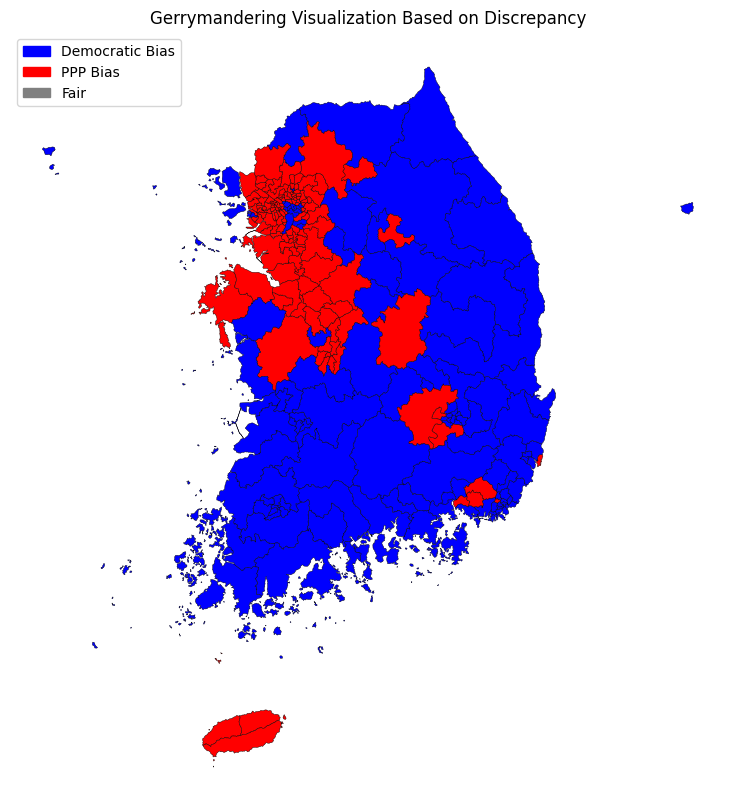

In [ ]:
# Function to classify districts based on discrepancy
def classify_by_discrepancy(row):
    if row['discrepancy'] > 0:
        return 'blue'  # Democratic Bias
    elif row['discrepancy'] < 0:
        return 'red'   # PPP Bias
    else:
        return 'gray'  # Fair

# Apply classification to the GeoDataFrame
result_gdf['color'] = result_gdf.apply(classify_by_discrepancy, axis=1)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
result_gdf.plot(ax=ax, color=result_gdf['color'], edgecolor='black', linewidth=0.3)

# Create a legend
legend_elements = [
    mpatches.Patch(color='blue', label='Democratic Bias'),
    mpatches.Patch(color='red', label='PPP Bias'),
    mpatches.Patch(color='gray', label='Fair')
]
ax.legend(handles=legend_elements, loc='upper left')

# Set title and remove axis
ax.set_title('Gerrymandering Visualization Based on Discrepancy')
plt.axis('off')

# Show the plot
plt.show()

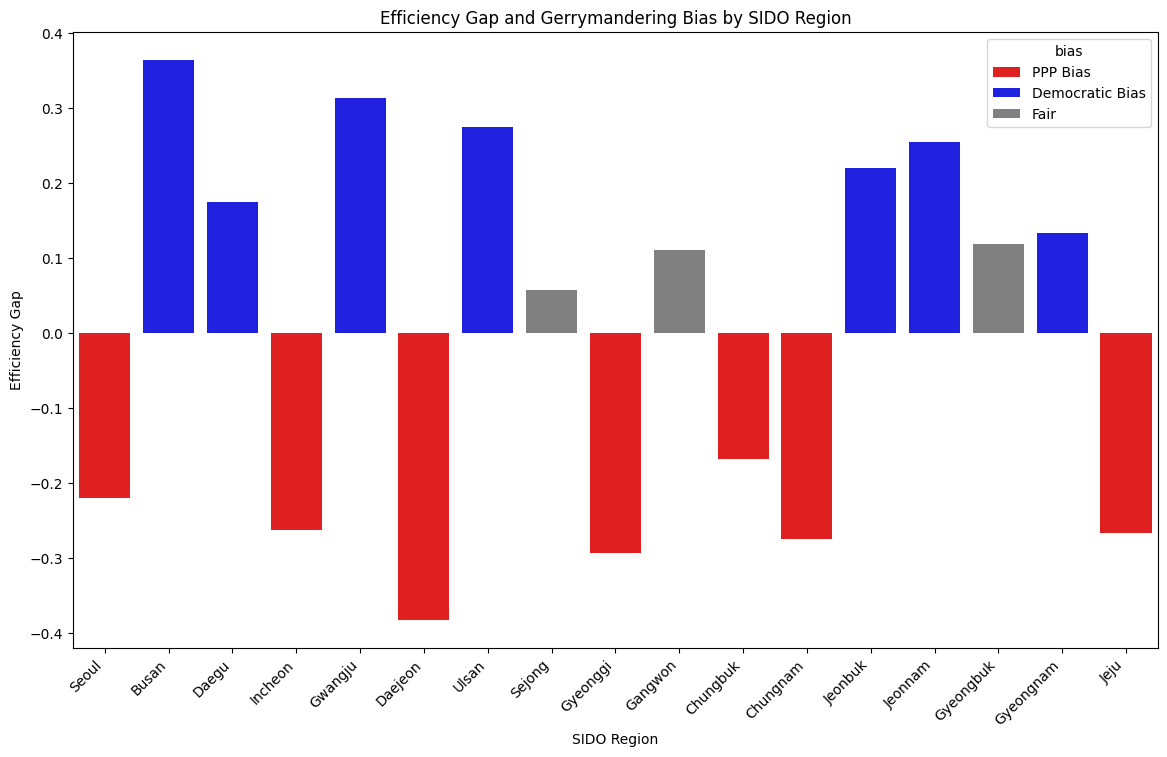

In [ ]:
plt.figure(figsize=(14, 8))

color_map = {'Democratic Bias': 'blue', 'PPP Bias': 'red', 'Fair': 'gray'}

sns.barplot(data=sido_df, x='SIDO', y='efficiency_gap', hue='bias', palette=color_map)

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.title('Efficiency Gap and Gerrymandering Bias by SIDO Region')
plt.xlabel('SIDO Region')
plt.ylabel('Efficiency Gap')

# Display the plot
plt.show()

# Conclusion
* Gerrymandering in favor of PPP appears to be a significant factor in the urban centers.
* Such as Seoul and Incheon, where the district boundaries might be crafted to ensure PPP's dominance despite losing the popular vote.
* Democratic regions continue to enjoy efficiency in their victories in rural and suburban areas.
* The efficiency gap shows how district boundaries can disproportionately affect election outcomes, highlighting the need for electoral reforms.